# Imports

In [77]:
import ete3
from urllib.request import urlopen
import xmltodict
import pandas as pd
import os
import seaborn as sns
from Bio import SeqIO
import collections
import matplotlib.pyplot as plt
import numpy as np
import dendropy
%matplotlib inline

# Define helper functions for plotting and decorating the trees 

In [130]:
def decorate(tree, bayes=False, prot=False):
    for leaf in tree:
        s = leaf.name.split('_')[1]
        if bayes:
            pID = leaf.name
        else:
            try:
                pID = leaf.name.split('|')[2]
            except:
                pID = leaf.name
        x= uniprot_meta(pID)
        taxa = x['uniprot']['entry']['organism']['lineage']['taxon']
        if s in metadata:
            n = metadata[s]
        else:
            n = taxa[0][0] + '|' + taxa[-1]
        k = n.split('|')[0]
        leaf.kingdom= k 
        
        leaf.protid = pID
        leaf.specID = s
        if '#text' not in x['uniprot']['entry']['organism']['name']:
            try:
                leaf.specie  = x['uniprot']['entry']['organism']['name'][0]['#text']
            except:
                print(x['uniprot']['entry']['organism']['name'])
        else:
            leaf.specie  = x['uniprot']['entry']['organism']['name']['#text']
        if 'recommendedName' in x['uniprot']['entry']['protein']:
            leaf.fullname = x['uniprot']['entry']['protein']['recommendedName']['fullName']['#text']
            leaf.shortname = x['uniprot']['entry']['protein']['recommendedName']['shortName']['#text']
        else:
            if len(x['uniprot']['entry']['protein']['submittedName']) != 1 and 'ecNumber' not in x['uniprot']['entry']['protein']['submittedName']:
                best= 0
                best_i = 0
                for i in range(len(x['uniprot']['entry']['protein']['submittedName'])):
                    e = int(x['uniprot']['entry']['protein']['submittedName'][i]['fullName']['@evidence'])
                    if e > best:
                        best = e
                        best_i = i
                leaf.fullname = x['uniprot']['entry']['protein']['submittedName'][best_i]['fullName']['#text']
                leaf.shortname = None
            else:
                leaf.fullname = x['uniprot']['entry']['protein']['submittedName']['fullName']['#text']
                leaf.shortname = None
        if 'Arthropoda' in taxa:
            k = 'Ar'
            leaf.kingdom=k
        nstyle = ete3.NodeStyle()
        if k == 'E':
            nstyle["fgcolor"] = "#55a868"
            nstyle["size"] = 15
        elif k == 'Ar':
            features = ''
            if 'feature' in x['uniprot']['entry']:
                feature = x['uniprot']['entry']['feature']            
                if type(feature) != collections.OrderedDict:
                    for i in feature:
                        if i['@type'] == 'domain':
                            features += i['@description'].lower()
                else:
                    if feature['@type'] == 'domain':
                        features = feature['@description'].lower()
            if 'osk' in leaf.fullname.lower():
                k = 'O'
            elif 'osk' in features:
                k = 'O'
            elif Test_Oskar(pID):
                k = 'O'
            if k == 'O':
                nstyle["fgcolor"] = "#8172b2"
                nstyle["size"] = 16
            else:
                nstyle["fgcolor"] = "#c44e52"
                nstyle["size"] = 15
            leaf.kingdom=k
        elif k == 'B':
            nstyle["fgcolor"] = "#4c72b0"
            nstyle["size"] = 15
        else:
            k = 'U'
            nstyle["fgcolor"] = "#ccb974"
            nstyle["size"] = 15
        leaf.set_style(nstyle)
        if leaf.shortname:
            n = leaf.shortname
        else:
            n = leaf.fullname
            if prot:
                leaf.name  =' '.join(leaf.specie.split(' ')[:2]) + ' - ' + n 
            else:
                if leaf.kingdom in ['B','A','U']:
                    leaf.name  =' '.join(leaf.specie.split(' ')[:4])
                else:
                    leaf.name  =' '.join(leaf.specie.split(' ')[:2])
    return tree
            
                

def uniprot_meta(accID):
    if not os.path.isfile('./uniprots/%s.xml' % accID):
        url = "http://www.uniprot.org/uniprot/%s.xml" % (accID)
        with urlopen(url) as response:
            xml = response.read()
#         handle = urlopen(url)
        xml = handle.read()
        f = open('./uniprots/%s.xml'%accID,'w')
        f.write(xml)
        f.close()
    else:
        xml = open('./uniprots/%s.xml'%accID).read()
    xml = xmltodict.parse(xml)
    return xml

def Parse_HMMER_output(path):
    f = open(path)
    lines = f.readlines()
    f.close()
    collumns = ['target name', 'Prot_ID', 'Specie_ID', 'accession', 'query name', 'accession', 'Pre E-value', 'Pre score', 'Pre bias', 'E-value', 'score', 'bias', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description of target']
    res = []
    for line in lines:
        if line[0] != '#':
            s = [i for i in line.split(' ') if i]
            s = [s[0]] + [s[0].split('|')[2]] + [s[0].split('|')[2].split('_')[1]] + s[1:18] + [' '.join(s[18:])]
            res.append(s)
    df = pd.DataFrame(res, columns=collumns)
    return df

def Test_Oskar(accID):
    print("Testing if oskar")
    exist = False
    if accID not in uniprot_dl:
        if not os.path.isfile('./tmp/%s.fasta' % accID):
            print("Cant find file")
            url = "http://www.uniprot.org/uniprot/%s.fasta" % (accID)
            with urlopen(url) as response:
#             handle = urllib2.urlopen(url)
                fasta = response.read()
            f = open('./tmp/%s.fasta' % accID, 'w')
            f.write(fasta.decode('utf-8'))
            f.close()
            handle = SeqIO.parse('./tmp/%s.fasta' % accID, 'fasta')
            try:
                for i in handle:
                    seq = i
                if i:
                    exist = True
                else:
                    exist = False
                uniprot_dl.append(accID)
            except:
                print(accID)
        else:
            exist = True
    else:
        exist = True
    if exist:
        os.system('hmmsearch --cpu 7 -o log_lotus --tblout test_oskar_lotus.out ' + '../../Data/HMM/LOTUS.hmm ' + './tmp/%s.fasta' % accID)
        os.system('hmmsearch --cpu 7 -o log_osk --tblout test_oskar_osk.out ' + '../../Data/HMM/OSK.hmm ' + './tmp/%s.fasta' % accID)
        lotus = Parse_HMMER_output("test_oskar_lotus.out")
        sgnh = Parse_HMMER_output("test_oskar_osk.out")
        if len(sgnh) > 0 and len(lotus) == 0:
            f = open('toCheck', 'a')
            f.write(accID + '\n')
        if len(lotus) > 0:
            if len(sgnh) > 0:
                return True
    return False

def Collapse_support(s, tree):
    a = tree.traverse()
    for i in a:
        if not i.name:
            if i.support < s:
                anc = i.get_ancestors()
                child = i.children
                if len(anc) > 0:
                    for c in child:
                        anc[-1].add_child(c)
                        i.detach()
                        
def remove_duplicate_specie(tree, ar=False):
    done = []
    for leaf in tree:
        if leaf.specID in done:
            if ar:
                if leaf.kingdom == 'Ar':
                    leaf.delete()
            else:
                leaf.delete()
        else:
            done.append(leaf.specID)
            
def DL_seq(accID, name):
    print("Doing ", accID)
    url = "http://www.uniprot.org/uniprot/%s.fasta" % (accID)
#     handle = urllib2.urlopen(url)
    with urlopen(url) as response:
        fasta = response.read()
    try:
        if fasta[0] == '>':
            f = open('./tmp/%s.fasta'%name, 'a')
            f.write(fasta)
            f.close()
    except:
        print("ERROR: ",accID)

# Define paths

In [131]:
taxonomy = '../../Data/taxonomy/uniprot_ID_taxa.tsv'

#RAXML TREES
LOTUS_animala_path = '../../Data/Trees/LOTUS.raxml.bipartitions'
SGNH_RaxML_noPut_path = '../../Data/Trees/OSK.raxml.bipartitions'

#Mr BAYES TREES
LOTUS_animala_Bayes_path = '../../Data/Trees/LOTUS.bayes.nexus.con.tre'
SGNH_Bayes_noPut_path = '../../Data/Trees/OSK.bayes.nexus.con.tre'


## Reading the metadata and loading the trees in a format compatible with ETE3

In [132]:
metadata = {}
f = open(taxonomy)
lines = f.readlines()
for i in range(len(lines)):
    line = lines[i].strip()
    s = line.split('\t')
    spec = s[2].split(',')[-1]
    kingdom = s[2].split(',')[0]
    acc = s[0]
    metadata[acc] = kingdom[0] + '|' + spec
uniprot_dl = []

In [133]:
data = dendropy.DataSet.get_from_path(LOTUS_animala_Bayes_path, "nexus")
data.write_to_path(LOTUS_animala_Bayes_path+ ".xml", "nexml")
LOTUS_animala_Bayes_path = LOTUS_animala_Bayes_path + '.xml'

data = dendropy.DataSet.get_from_path(SGNH_Bayes_noPut_path, "nexus")
data.write_to_path(SGNH_Bayes_noPut_path+ ".xml", "nexml")
SGNH_Bayes_noPut_path = SGNH_Bayes_noPut_path+ ".xml"



# Tree Plotting 

## Define the style parameters for the trees of Figure 2

In [134]:
ts = ete3.TreeStyle()
ts.mode = "c"
ts.arc_span = 180
ts.arc_start = -180
ts.scale = 70
ts.draw_guiding_lines = True
ts.optimal_scale_level = 'mid'
ts.show_branch_support = False
ts.show_scale = False
ts.show_leaf_name = True
ts.complete_branch_lines_when_necessary = True

# LOTUS Bayes Tree Circular for Figure 2

## Creating the tree and decorating it

In [135]:
nexml_project = ete3.Nexml()
nexml_project.build_from_file(LOTUS_animala_Bayes_path)
otu2name = {}
for taxa in  nexml_project.get_otus():
    for otu in taxa.get_otu():
        otu2name[otu.id] = otu.label.replace(' ','_')
        
tree_collections = nexml_project.get_trees()
collection_1 = tree_collections[0]
LOTUS_bayes = collection_1.get_tree()[0]
    # trees contain all the nexml information in their "nexml_node",
    # "nexml_tree", and "nexml_edge" attributes.

for node in LOTUS_bayes.traverse():
    if node.nexml_node.otu:
        node.name = otu2name[node.nexml_node.otu]
    for l in node.nexml_node.meta:
        if l.property == 'dendropy:prob(percent)':
            node.support = l.content

new = LOTUS_bayes.write('test.newick')
LOTUS_bayes = ete3.Tree(new)
LOTUS_bayes = decorate(LOTUS_bayes, bayes=True, prot=True)

trav = LOTUS_bayes.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in LOTUS_bayes:
    if leaf.kingdom == 'B':
        LOTUS_bayes.set_outgroup( leaf )
    n = leaf.name
    prot= n.split(' - ')[1]
    if 'tudor' in prot.lower():
        if '5' in prot:
            prot = 'Tud5'
        elif '7' in prot:
            prot = 'Tud7'
        else:
            prot = 'Tud?'
    elif leaf.kingdom == 'O':
        prot = 'Oskar'
    else:
        prot = 'Ukn'
    leaf.name = '  ' + leaf.name.split(' - ')[0] + ' - ' + prot

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar


In [136]:
handle = SeqIO.parse('./tmp/A0A0K8TEH4_LYGHE.fasta', 'fasta')


## Plotting the tree

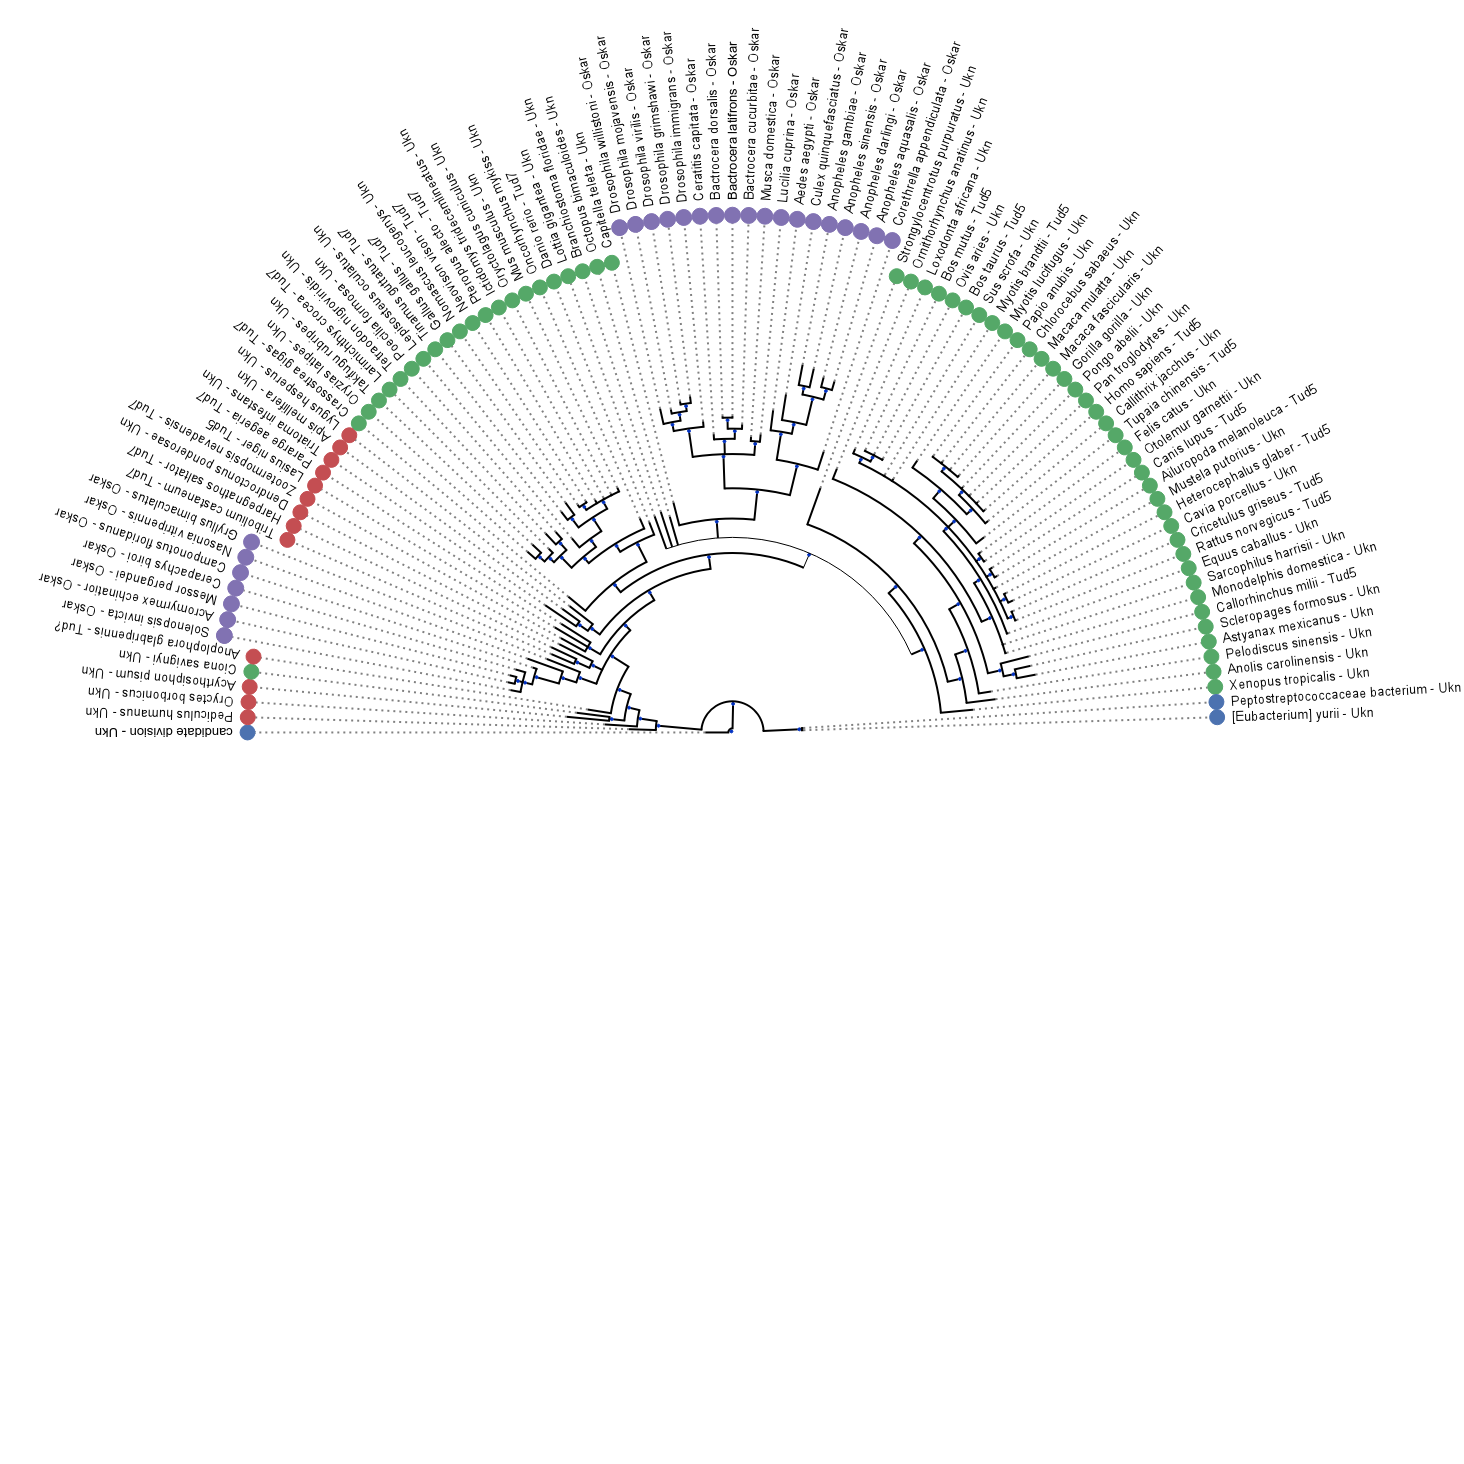

In [137]:
LOTUS_bayes.render('%%inline', tree_style=ts)
# LOTUS_bayes.render('Figure2_Lotus_Bayes_circular.pdf', tree_style=ts, units='mm', w=183, dpi=600)

# OSK Bayes Tree Circular for Figure 2

## Creating the tree and decorating it

In [138]:
nexml_project = ete3.Nexml()
nexml_project.build_from_file(SGNH_Bayes_noPut_path)
otu2name = {}
for taxa in  nexml_project.get_otus():
    for otu in taxa.get_otu():
        otu2name[otu.id] = otu.label.replace(' ','_')
        
tree_collections = nexml_project.get_trees()
collection_1 = tree_collections[0]
SGNH_Bayes_noPut = collection_1.get_tree()[0]
    # trees contain all the nexml information in their "nexml_node",
    # "nexml_tree", and "nexml_edge" attributes.

for node in SGNH_Bayes_noPut.traverse():
    if node.nexml_node.otu:
        node.name = otu2name[node.nexml_node.otu]
    for l in node.nexml_node.meta:
        if l.property == 'dendropy:prob(percent)':
            node.support = l.content
new = SGNH_Bayes_noPut.write('test.newick')

SGNH_Bayes_noPut = ete3.Tree(new)
SGNH_Bayes_noPut = decorate(SGNH_Bayes_noPut, bayes=True)

trav = SGNH_Bayes_noPut.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in SGNH_Bayes_noPut:
    leaf.name = '  ' + leaf.name + '  '
    if 'Methano' in leaf.name:
        print(leaf)
        SGNH_Bayes_noPut.set_outgroup( leaf )
    if leaf.kingdom == 'Ar':
        leaf.detach()
        
for node in SGNH_Bayes_noPut.traverse():
    if 'drosophila' in node.name.lower():
        node1 = node
    if 'firmicute' in node.name.lower():
        node2 = node
    if 'arcobacter' in node.name.lower():
        node3 = node
    if 'mycel' in node.name.lower():
        node4 = node
todetach = SGNH_Bayes_noPut.get_common_ancestor(node3, node4)
toattach = SGNH_Bayes_noPut.get_common_ancestor(node1, node3)
nodes = todetach.detach()
toattach.add_child(nodes)

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Cant find file
Testing if oskar
Cant find file
Testing if oskar
Cant find file
Testing if oskar
Cant find file
Testing if oskar
Cant find file
Testing if oskar
Cant find file
Testing if oskar
Testing if oskar

--  Methanosarcina barkeri str. Wiesmoor  

--  Methanosarcina barkeri CM1  


Tree node '' (0x7fb0c227f16)

## Reversing the tree to plot a circle

In [139]:
ts.arc_start = 0 

## Plotting the tree

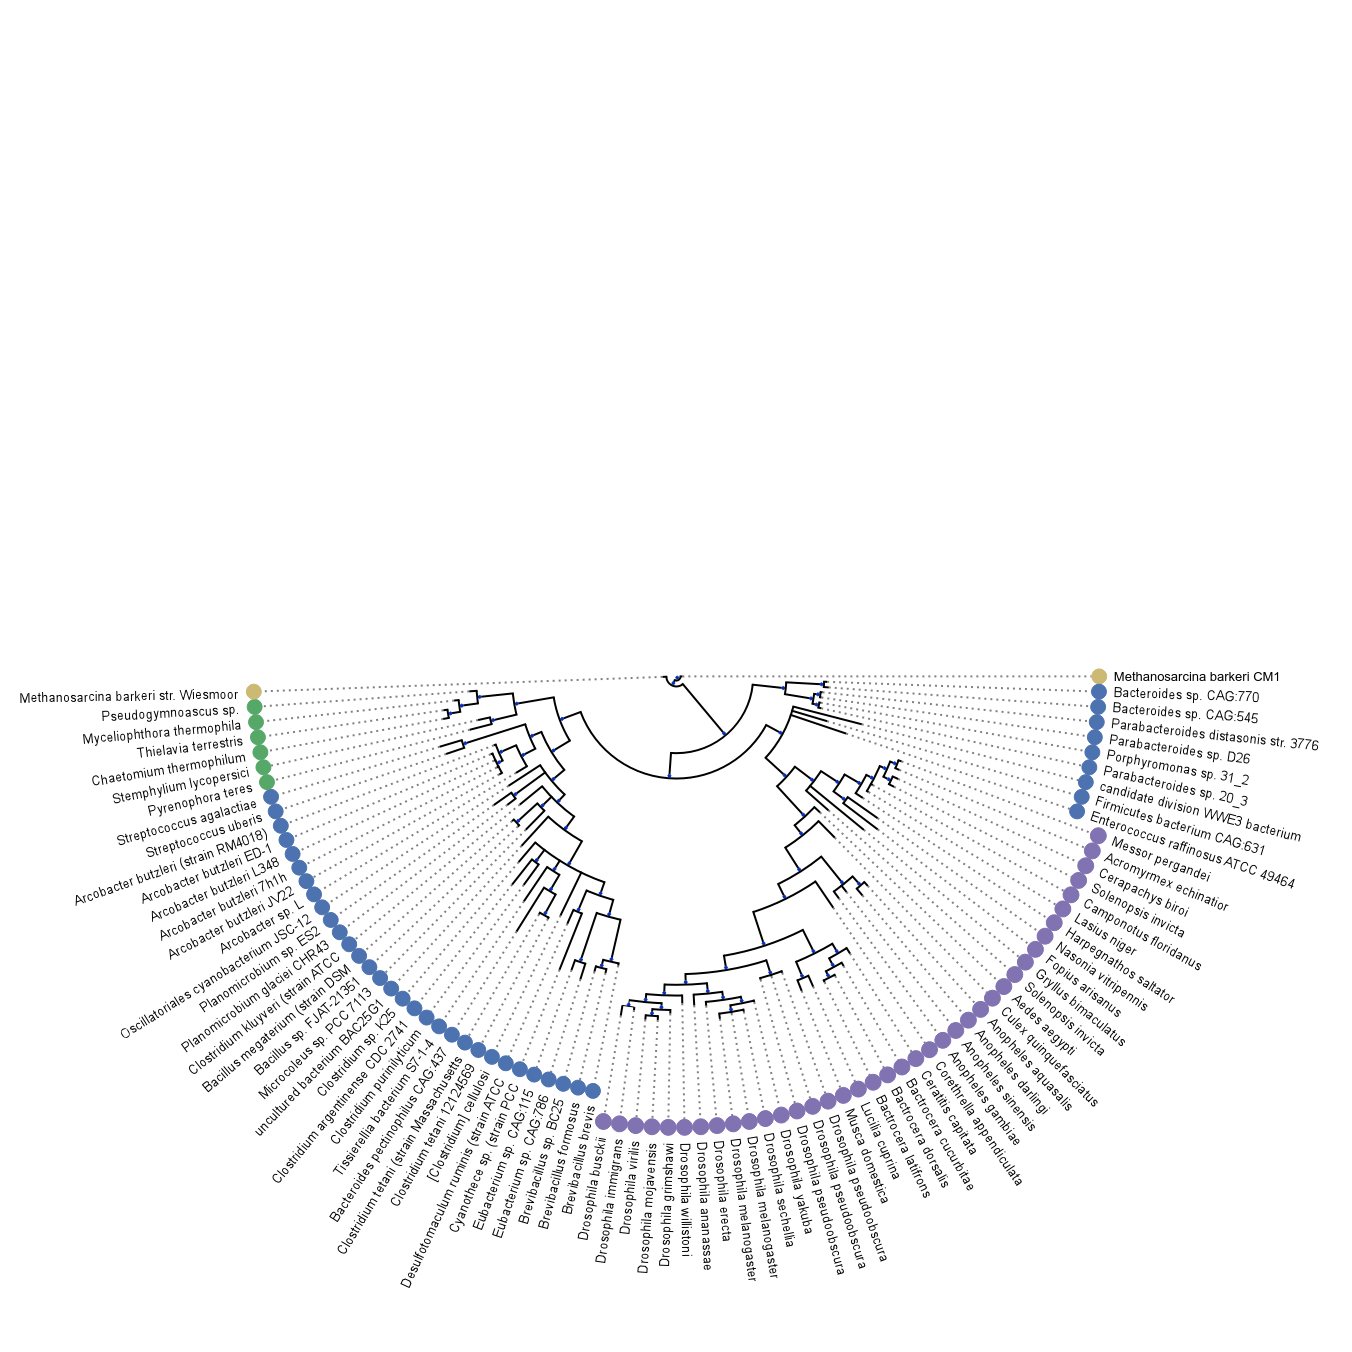

In [140]:
SGNH_Bayes_noPut.render('%%inline', tree_style=ts)
# SGNH_Bayes_noPut.render('Figure2_SGNH_Bayes_circular.pdf', tree_style=ts, units='mm', w=183, dpi=600)

# Defining Parameters for Supp Info Trees

In [141]:
ts = ete3.TreeStyle()
ts.show_branch_support = True
ts.show_scale = False
ts.show_leaf_name = True
ts.complete_branch_lines_when_necessary = True

# LOTUS Trees for Figure S1 and S2

## RaxML tree

### Creating and decorating the tree

In [142]:
LOTUS_animala = ete3.Tree(open(LOTUS_animala_path).read())
LOTUS_animala = decorate(LOTUS_animala)
for leaf in LOTUS_animala:
    if leaf.kingdom == 'B':
        LOTUS_animala.set_outgroup( leaf )
trav = LOTUS_animala.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in LOTUS_animala:
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar


### Plotting the tree

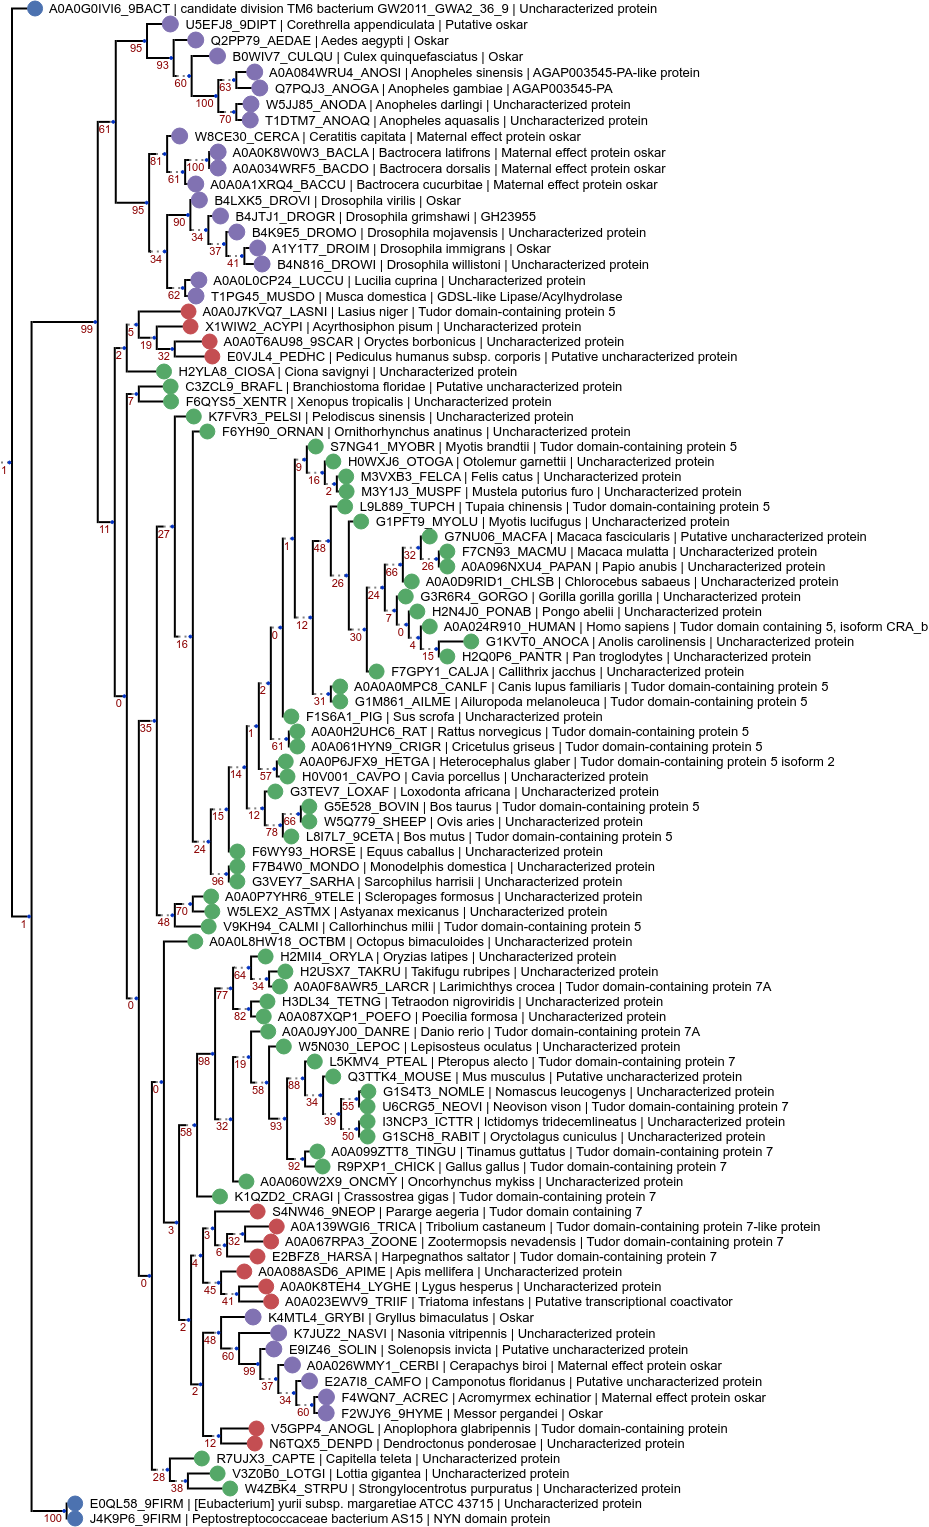

In [143]:
LOTUS_animala.render('%%inline', tree_style=ts)

In [144]:
LOTUS_animala.render('FigureS1.pdf', tree_style=ts, units='mm', h=247, dpi=600)
LOTUS_animala.render('FigureS1.png', tree_style=ts, units='mm', h=247, dpi=600)

{'faces': [[1235.1746711381384,
   1677.4128658849115,
   2817.0628863462325,
   1734.727656291002,
   67,
   '  S7NG41_MYOBR | Myotis brandtii | Tudor domain-containing protein 5'],
  [642.4214912650191,
   1104.264961824008,
   692.094309616964,
   1150.1167941488802,
   36,
   '62'],
  [871.4816137777169,
   4718.917743434774,
   921.1544321296619,
   4764.769575759647,
   165,
   '32'],
  [821.0527470754404,
   1620.0980754788213,
   2410.58293433768,
   1677.4128658849115,
   58,
   '  F6YH90_ORNAN | Ornithorhynchus anatinus | Uncharacterized protein'],
  [1120.4468864814899,
   2881.0234644128095,
   3191.4213131548886,
   2938.3382548188997,
   105,
   '  A0A0P6JFX9_HETGA | Heterocephalus glaber | Tudor domain-containing protein 5 isoform 2'],
  [1038.7036798946936,
   2401.6147209760334,
   1065.4505820842023,
   2447.4665533009056,
   64,
   '0'],
  [602.8289327457125,
   1337.345109475442,
   652.5017510976575,
   1383.1969418003143,
   45,
   '32'],
  [908.0231657901599,
   

## Mr Bayes tree

### Decorating the tree

In [145]:
for leaf in LOTUS_bayes:
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

### Plotting the tree

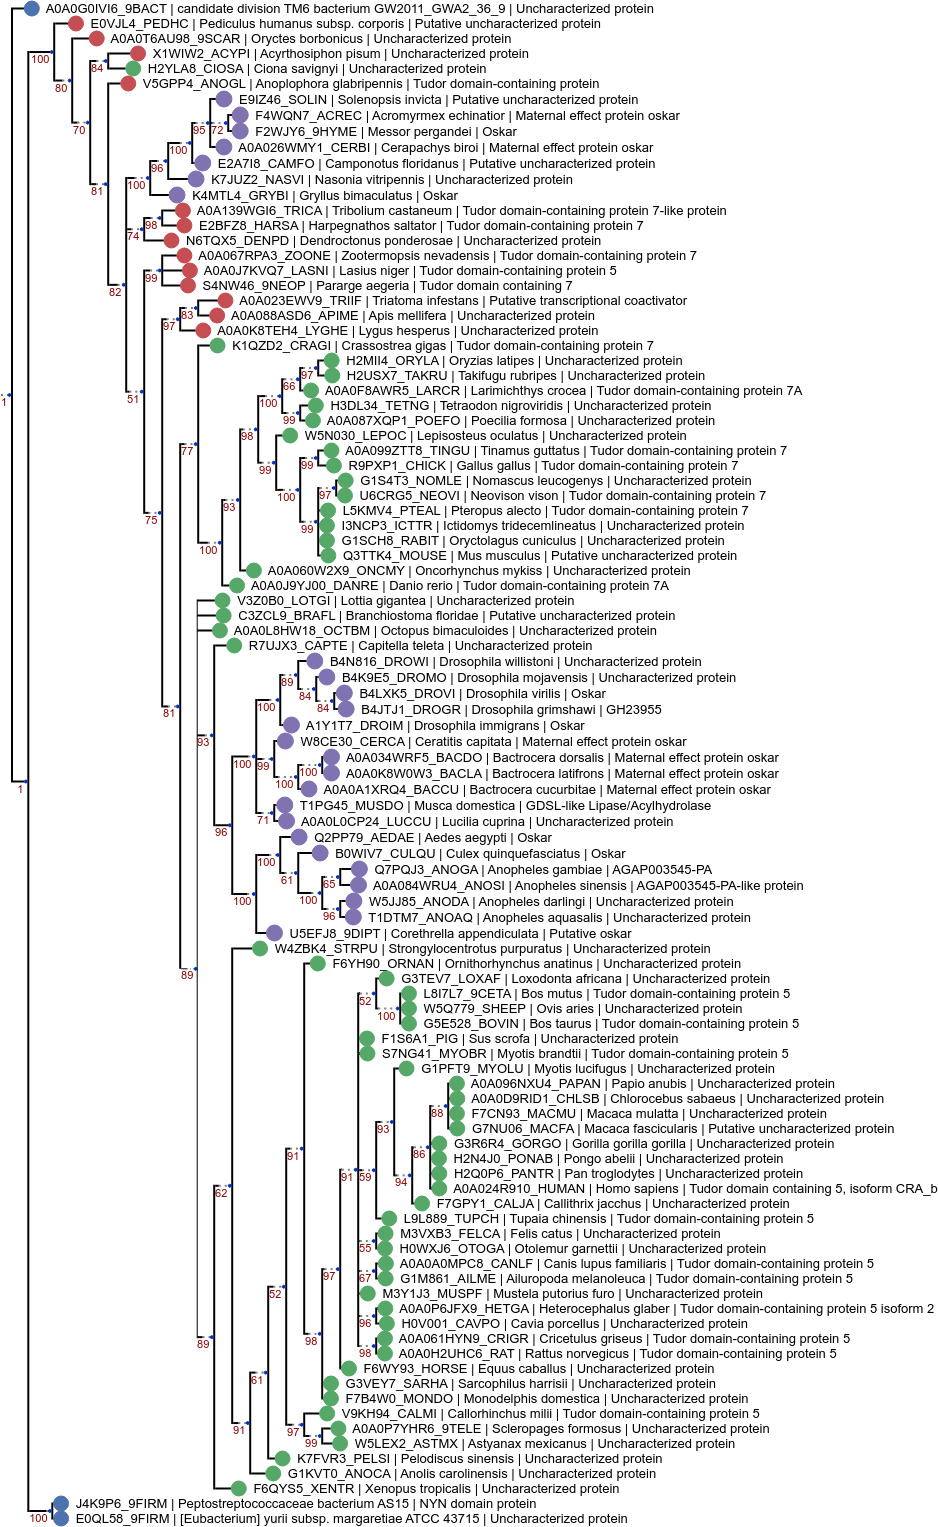

In [146]:
LOTUS_bayes.render('%%inline', tree_style=ts)

In [147]:
LOTUS_bayes.render('FigureS2.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
LOTUS_bayes.render('FigureS2.png', tree_style=ts, units='mm', h=247,  dpi=600)

{'faces': [[1297.2748062775843,
   2863.8290272909826,
   2982.329644216641,
   2921.143817697073,
   94,
   '  A0A034WRF5_BACDO | Bactrocera dorsalis | Maternal effect protein oskar'],
  [982.9189323157154,
   2903.949380575246,
   1032.5917506676603,
   2949.801212900118,
   90,
   '99'],
  [1211.2775625162408,
   2986.1005801573087,
   2949.8262048343154,
   3043.415370563399,
   96,
   '  A0A0A1XRQ4_BACCU | Bactrocera cucurbitae | Maternal effect protein oskar'],
  [733.3208866979201,
   947.6045347140275,
   2666.7398163967023,
   1004.919325120118,
   33,
   '  A0A067RPA3_ZOONE | Zootermopsis nevadensis | Tudor domain-containing protein 7'],
  [1173.4614917089602,
   3169.5079094567977,
   2113.424054368842,
   3226.822699862888,
   102,
   '  Q2PP79_AEDAE | Aedes aegypti | Oskar'],
  [1235.4839367746092,
   1520.7524387749313,
   2721.847501305886,
   1578.0672291810217,
   55,
   '  H3DL34_TETNG | Tetraodon nigroviridis | Uncharacterized protein'],
  [1705.9103718906124,
   439

# OSK Trees for Figure S3 and S4

## RaxML tree

### Creating and decorating the tree

In [148]:
SGNH_RaxML_noPut = ete3.Tree(open(SGNH_RaxML_noPut_path).read())
decorate(SGNH_RaxML_noPut, bayes=False)
for leaf in SGNH_RaxML_noPut:
    if 'milii' in leaf.name:
        SGNH_RaxML_noPut.set_outgroup( leaf )
remove_duplicate_specie(SGNH_RaxML_noPut, ar=True)
trav = SGNH_RaxML_noPut.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in SGNH_RaxML_noPut:
    if "candidate division" in leaf.specie:
        leaf.name = 'WWE3 bacterium'
    if leaf.kingdom == 'A':
        print(leaf)
        SGNH_RaxML_noPut.set_outgroup( leaf )
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar

--Methanosarcina barkeri CM1

--Methanosarcina barkeri str. Wiesmoor


### Plotting the tree

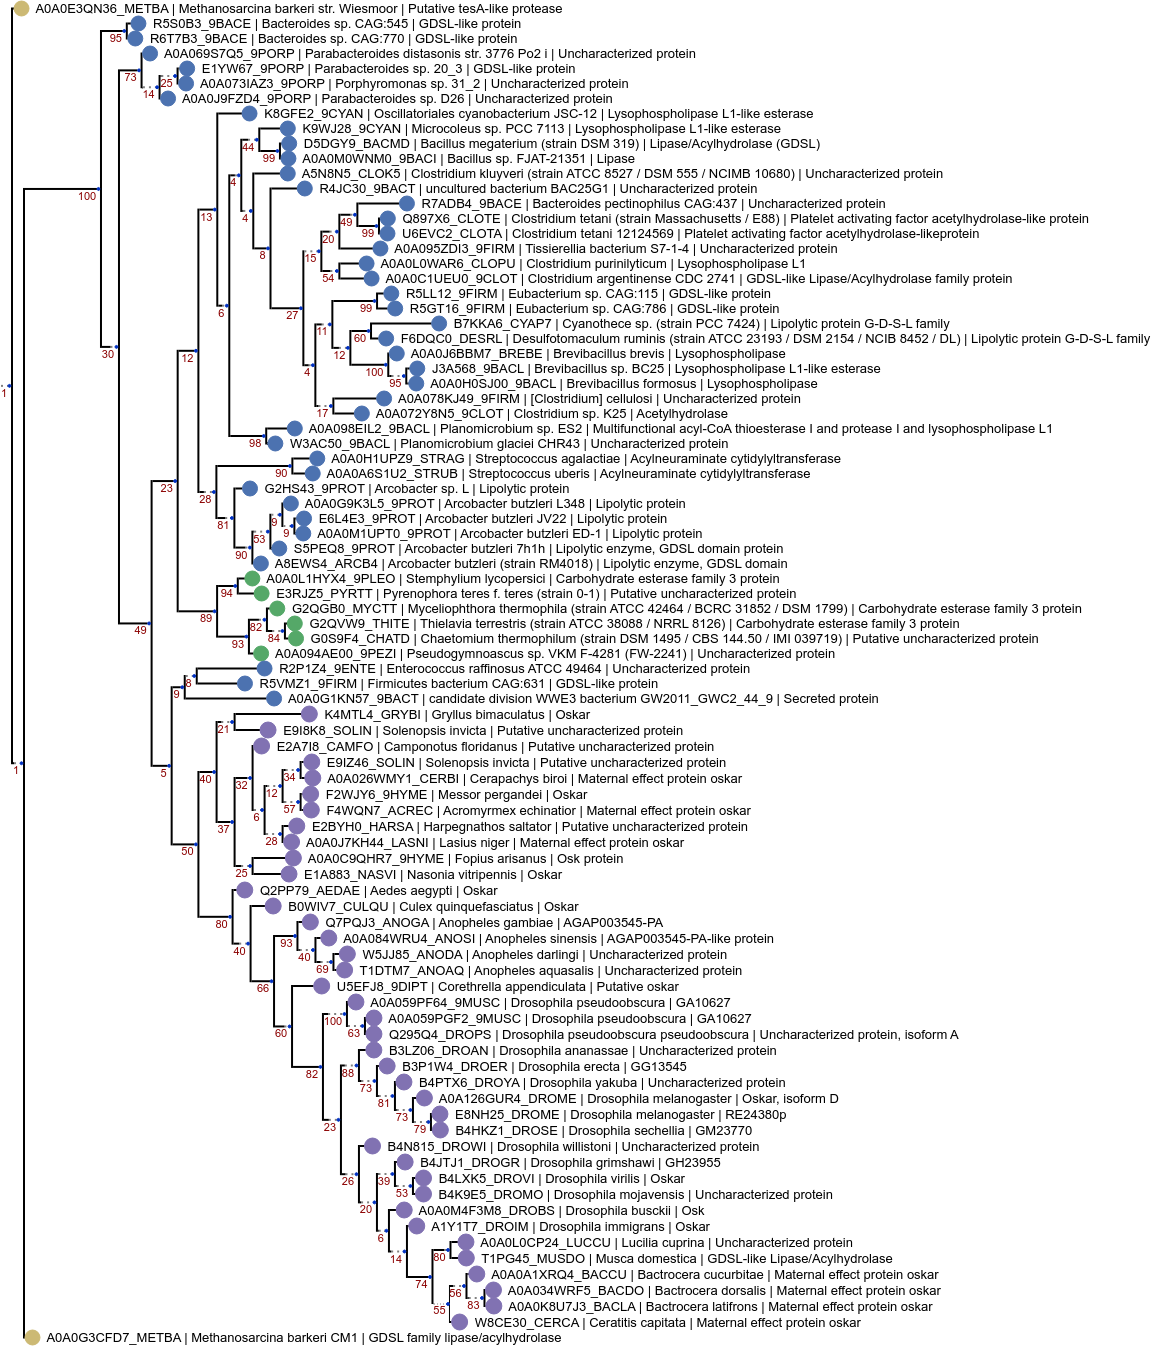

In [149]:
SGNH_RaxML_noPut.render('%%inline', tree_style=ts)

In [150]:
SGNH_RaxML_noPut.render('FigureS3.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_RaxML_noPut.render('FigureS3.png', tree_style=ts, units='mm', h=247,  dpi=600)

{'faces': [[1287.507127695844,
   3756.10733082029,
   2444.8996924148487,
   3821.129385017987,
   116,
   '  E1A883_NASVI | Nasonia vitripennis | Oskar'],
  [1098.3817369636565,
   2308.824774469887,
   1154.7341839349938,
   2360.8424178280443,
   70,
   '53'],
  [1687.4129098282717,
   1634.2209621687816,
   1743.7653567996092,
   1686.2386055269392,
   54,
   '95'],
  [583.4974818472657,
   2706.8327160594813,
   639.849928818603,
   2758.850359417639,
   15,
   '49'],
  [1321.2344757978283,
   3548.03675738766,
   3245.887280049656,
   3613.058811585357,
   112,
   '  E2BYH0_HARSA | Harpegnathos saltator | Putative uncharacterized protein'],
  [1404.2636035692913,
   4858.637537309988,
   1460.6160505406285,
   4910.6551806681455,
   137,
   '23'],
  [1021.2579657532648,
   3376.812014667058,
   1077.6104127246022,
   3428.829658025216,
   101,
   '32'],
  [1353.7442418796174,
   784.5994539855424,
   3287.066653357805,
   849.6215081832393,
   30,
   '  R4JC30_9BACT | uncultured

## Bayes tree

### Decorating the tree

In [151]:
for leaf in SGNH_Bayes_noPut:
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

### Plotting the tree

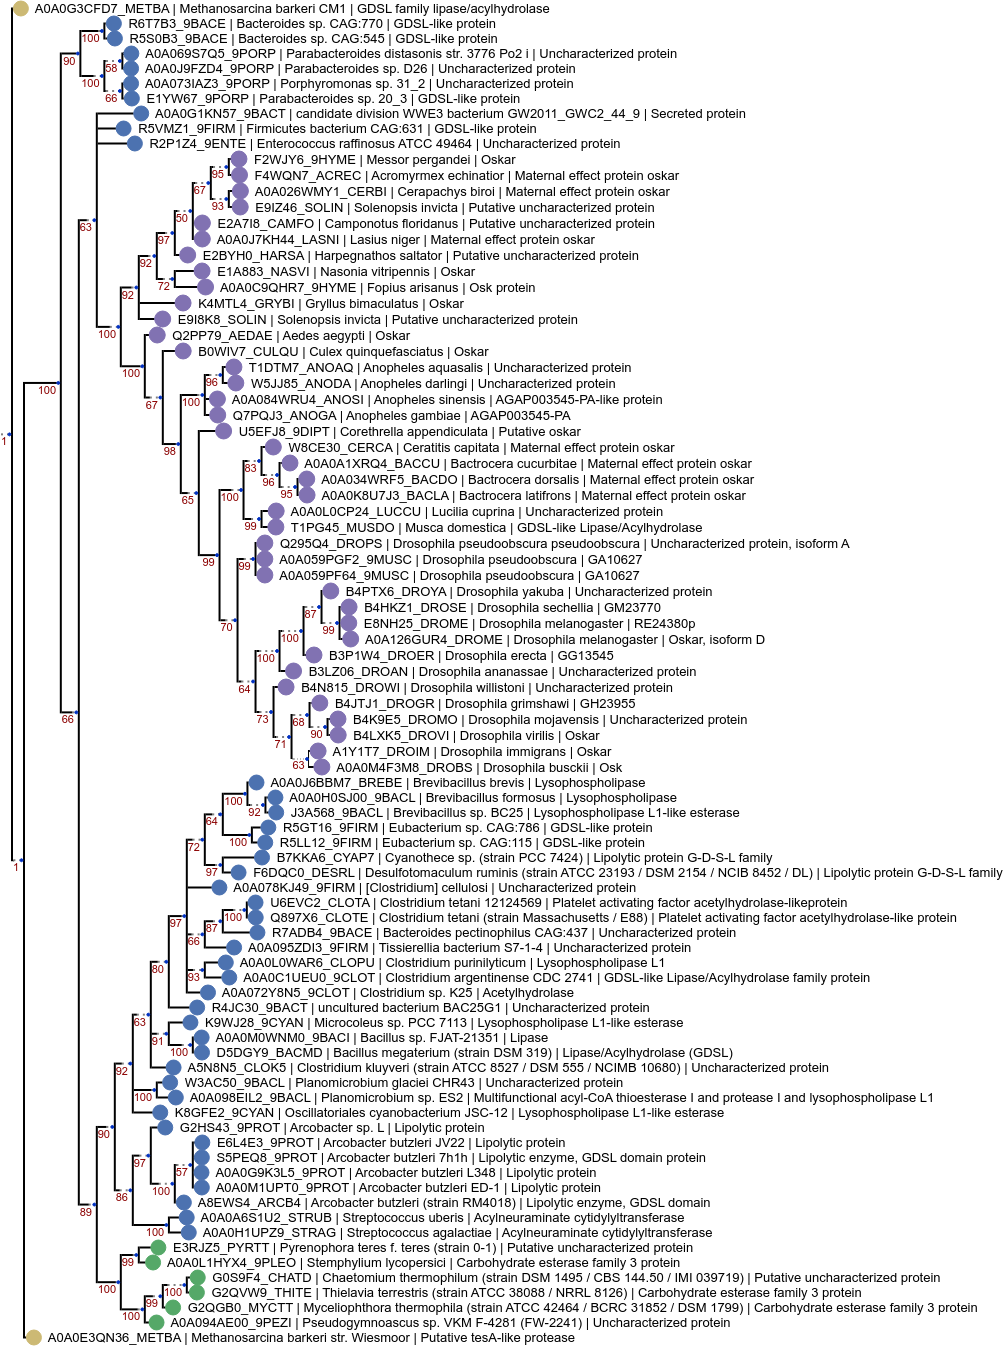

In [152]:
SGNH_Bayes_noPut.render('%%inline', tree_style=ts)

In [153]:
SGNH_Bayes_noPut.render('FigureS4.pdf', tree_style=ts, units='mm', h=247, dpi=600)
SGNH_Bayes_noPut.render('FigureS4.png', tree_style=ts, units='mm', h=247, dpi=600)

{'faces': [[1346.1121152470698,
   3155.7370303948887,
   1402.464562218407,
   3207.754673753046,
   86,
   '90'],
  [632.0564469620757,
   1727.4869711586032,
   688.408893933413,
   1779.5046145167607,
   42,
   '67'],
  [925.7890651211162,
   1211.5776098837518,
   2325.9306321781887,
   1276.5996640814487,
   37,
   '  A0A0C9QHR7_9HYME | Fopius arisanus | Osk protein'],
  [502.01233856668193,
   4614.720169935555,
   558.3647855380192,
   4666.737813293712,
   94,
   '92'],
  [1182.793304662058,
   2321.2873348577787,
   3683.9749894667984,
   2386.3093890554755,
   67,
   '  Q295Q4_DROPS | Drosophila pseudoobscura pseudoobscura | Uncharacterized protein, isoform A'],
  [528.0211602457607,
   5444.513338153819,
   584.373607217098,
   5496.530981511976,
   148,
   '99'],
  [1546.5475105726875,
   2668.071623912162,
   3016.045935440637,
   2733.093678109859,
   77,
   '  E8NH25_DROME | Drosophila melanogaster | RE24380p'],
  [814.1181987156269,
   3644.2152125550865,
   870.470645